In [ ]:
import os, csv, string, re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras


from matplotlib import rcParams
from sklearn import preprocessing, model_selection
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from time import time
from sklearn.model_selection import GridSearchCV

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
!tar -xvf /content/webkb-data.gtar.gz

Streaming output truncated to the last 5000 lines.
webkb/other/texas/http:^^www.cs.utexas.edu^users^zhouxiao^institute.html
webkb/other/texas/http:^^www.cs.utexas.edu^users^dastuart^tempjdir^jokes^jokes.html
webkb/other/texas/http:^^www.cs.utexas.edu^users^luxue^company.html
webkb/other/texas/http:^^www.utexas.edu^teamweb
webkb/other/texas/http:^^www.cs.utexas.edu^cgi^rwho^sunghee
webkb/other/texas/http:^^www.cs.utexas.edu^users^emery^fp+oop=haskell^fp+oop=haskell.html
webkb/other/texas/http:^^www.ticam.utexas.edu^Groups^Composites^index.html
webkb/other/texas/http:^^www.cs.utexas.edu^users^bayardo^papers.html
webkb/other/texas/http:^^www.cs.utexas.edu^users^vbb^eosdis-bm.html
webkb/other/texas/http:^^www.cs.utexas.edu^users^jadair^compound.html
webkb/other/texas/http:^^www.cs.utexas.edu^docs^prof.html
webkb/other/texas/http:^^www.cs.utexas.edu^users^boyer^how-to-gnu-at-ut.html
webkb/other/texas/http:^^www.cs.utexas.edu^users^boyer^boyer-photo.html
webkb/other/texas/http:^^www.cs.utexa

In [ ]:
# Convert downloaded data into csv format
labels = []
directory = '/content/webkb/'
entries = []

for filename in os.listdir(directory):
  label = filename
  for filename in os.listdir(directory + label + '/'):
    uni = filename
    for filename in os.listdir(directory + label + '/' + uni + '/'):
      thisdict = {
          "label" : label,
          "uni" : uni,
          "url" : filename
      }
      entries.append(thisdict)
      
os.chdir('/content')
csv_file = 'web-data.csv'

with open(csv_file, 'w', newline='') as csvfile:
    categories = ['label', 'university', 'url']
    writer = csv.DictWriter(csvfile, fieldnames=categories)
    writer.writeheader()
    for entry in entries:
      writer.writerow({categories[0] : entry["label"], categories[1] : entry["uni"], categories[2] : entry["url"]})
  


In [ ]:
data = pd.read_csv(csv_file, encoding="latin-1", on_bad_lines='skip')
print(data[0:10])

     label  university                                                url
0  project  washington  http:^^www.cs.washington.edu^research^projects...
1  project  washington  http:^^www.cs.washington.edu^research^projects...
2  project  washington  http:^^www.cs.washington.edu^research^projects...
3  project  washington  http:^^www.cs.washington.edu^research^communit...
4  project  washington  http:^^www.cs.washington.edu^research^projects...
5  project  washington  http:^^www.cs.washington.edu^research^projects...
6  project  washington  http:^^www.cs.washington.edu^research^projects...
7  project  washington  http:^^www.cs.washington.edu^homes^levy^opal^o...
8  project  washington    http:^^www.cs.washington.edu^homes^romer^rocky^
9  project  washington  http:^^www.cs.washington.edu^research^metip^me...


other         3764
student       1641
faculty       1124
course         930
project        504
department     182
staff          137
Name: label, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


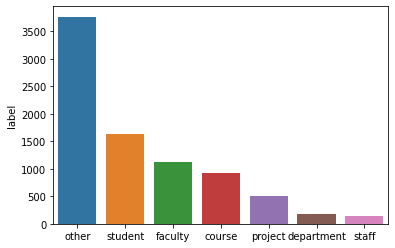

In [ ]:
# EDA

# Class distribution
x = data['label'].value_counts()
print(x)
sns.barplot(x.index,x)

In [ ]:
def float_string(input):
  return "{:.2f}".format(input)

total = 0
for i in x:
  total += i
total


for i in x:
  print(str(float_string((i/total)*100)) + "%")

45.45%
19.81%
13.57%
11.23%
6.09%
2.20%
1.65%


In [ ]:
# Missing values
data.isna().sum() # No missing values

label         0
university    0
url           0
dtype: int64

In [ ]:
# Preprocessing
# Convert all to lowercase, strip and remove punctuations

def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    # text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\s+',' ',text) 
    return text

def stopwords(text):
  words = ["http", "www", "html"]
  a= [i for i in text.split() if i not in words]
  return ' '.join(a)

def tokenization(text):
  return text.split()

  
def final_preprocessing(text):
  return tokenization(stopwords(preprocess(text)))

In [ ]:
data['clean_url'] = data['url'].apply(lambda x: final_preprocessing(x))
print(data['clean_url'].head)

# Label encoding
label_encoder = preprocessing.LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])
data['label']

num_class = len(pd.unique(data['label']))
num_class


<bound method NDFrame.head of 0       [cs, washington, edu, research, projects, grai...
1        [cs, washington, edu, research, projects, weird]
2          [cs, washington, edu, research, projects, zpl]
3       [cs, washington, edu, research, community, net...
4       [cs, washington, edu, research, projects, lis,...
                              ...                        
8277                               [cs, pitt, edu, index]
8278                                        [cs, mun, ca]
8279                                   [cs, cornell, edu]
8280                                      [cs, wisc, edu]
8281                                    [cs, utexas, edu]
Name: clean_url, Length: 8282, dtype: object>


7

In [ ]:
# Url length per category after preprocessing

data['url_length'] = data['clean_url'].apply(lambda x: len(x))
print("URL Length Averages")
for i in range(num_class):
  print("Class " + str(i) + ": " + str(data[data['label']==i]['url_length'].mean()))

URL Length Averages
Class 0: 6.490322580645161
Class 1: 3.681318681318681
Class 2: 5.455516014234876
Class 3: 6.797821466524973
Class 4: 5.6646825396825395
Class 5: 5.197080291970803
Class 6: 5.184034125533212


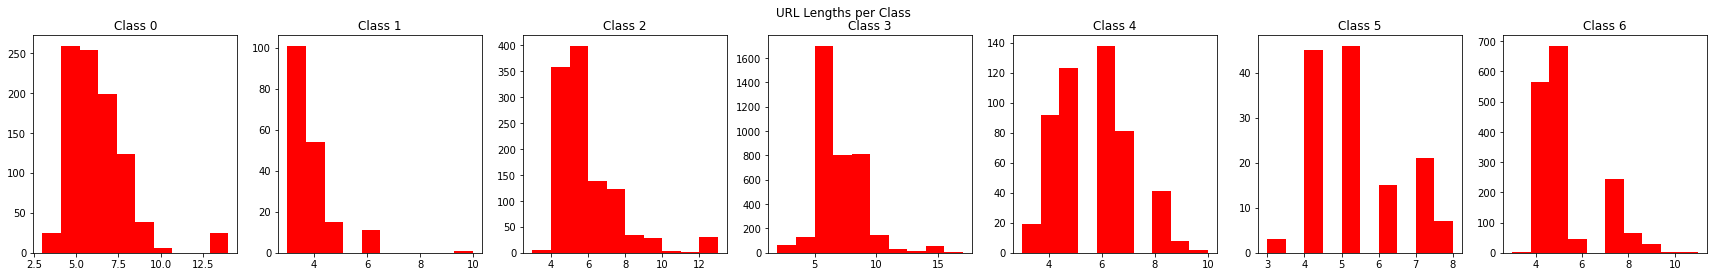

In [ ]:
# Plot URL length

graphs = [0,1,2,3,4,5,6]
fig, graphs = plt.subplots(1,7, figsize=(30, 4))
for i in range(len(graphs)):
  graph = graphs[i]
  plot_urls = data[data['label']==i]['url_length']
  graph.hist(plot_urls, color='red')
  graph.set_title('Class ' + str(i))
fig.suptitle('URL Lengths per Class')
plt.show()

In [ ]:
# Convert clean_url list to string for tfidf vectorizer
def joining(words):
  string_words =' '.join([str(item) for item in words])
  return string_words

data['string_clean_url'] = data['clean_url'].apply(lambda x : joining(x))

# Split into training and test
train_x, test_x, train_y, test_y = model_selection.train_test_split(data['string_clean_url'],
    data['label'], test_size=0.2, shuffle=True)

# Run TF-IDF tokenizing
tfidf_vectorizer = TfidfVectorizer(use_idf=True)

In [ ]:
# Determine the max length of the urls
i = 0
max_length = 0
for i in range(len(data)):
  if(len(data['string_clean_url'][i]) > max_length):
    max_length = len(data['string_clean_url'][i])

max_length = 100

In [ ]:
# Different non-cnn classifiers to check against the cnn algorithm
names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "Perceptron","Passive-Aggresive", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False))),
  ('classification', LinearSVC(penalty="l2"))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(),
    AdaBoostClassifier(),
    Perceptron(),
    PassiveAggressiveClassifier(),
    NearestCentroid()
    ]

zipped_clf = zip(names,classifiers)

In [ ]:
# Output a summary of accuracy
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

In [ ]:
# Run classifier pipeline
def classifier_comparator(vectorizer=tfidf_vectorizer, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, train_x, train_y, test_x, test_y)
        result.append((n,clf_accuracy,tt_time))
    return result

In [ ]:
# Apply existing classifiers to compare accuracy
# Source of code:
# https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-5-50b4e87d9bdd

trigram_result = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression()


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


null accuracy: 88.41%
accuracy score: 70.91%
model is 17.50% less accurate than null accuracy
train and test time: 7.55s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 88.41%
accuracy score: 66.08%
model is 22.33% less accurate than null accuracy
train and test time: 0.48s
--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


null accuracy: 88.41%
accuracy score: 71.27%
model is 17.14% less accurate than null accuracy
train and test time: 1.75s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB()
null accuracy: 88.41%
accuracy score: 66.75%
model is 21.67% less accurate than null accuracy
train and test time: 0.26s
--------------------------------------------------------------------------------
Validation result for Bernoulli NB
BernoulliNB()
null accuracy: 88.41%
accuracy score: 58.78%
model is 29.63% less accurate than null accuracy
train and test time: 0.30s
--------------------------------------------------------------------------------
Validation result for Ridge Classifier
RidgeClassifier()
null accuracy: 88.41%
accuracy score: 68.86%
model is 19.55% less accurate than null accuracy
train and test time: 0.61s
--------------------------------------------------------------------------------
Validation result for AdaBoost
Ad

In [ ]:
# word to integer ID tokenizing + padding
# tokenizer = text.Tokenizer()
oov_token = "<OOV>"
tokenizer = text.Tokenizer(oov_token=oov_token)
tokenizer.fit_on_texts(data['string_clean_url'])
word_index = tokenizer.word_index

train_x_seq = sequence.pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=17)
test_x_seq = sequence.pad_sequences(tokenizer.texts_to_sequences(test_x), maxlen=17)

train_y = to_categorical(train_y, num_class)
test_y = to_categorical(test_y, num_class)

In [ ]:
# Baseline CNN on tokenized urls - without embeddings
vocab_size = len(word_index)+1

model = Sequential()
model.add(layers.Embedding(vocab_size, 100))
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu')) 


model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(32, input_shape=(vocab_size, )))
model.add(layers.Activation(activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(num_class))
model.add(layers.Activation('softmax'))

model.summary()

opt = SGD(learning_rate=0.001)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(train_x_seq.shape)
print(train_y.shape)

history = model.fit(
    train_x_seq,
    train_y,
    epochs=10,
    batch_size=100,
    validation_split=0.1,
    verbose=1)

results = model.evaluate(test_x_seq, test_y)
original_results = results


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         715300    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         64128     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 activation (Activation)     (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                        

In [ ]:
# Function for plotting accuracy and loss
def plot_model(a, b, title, ylabel, xlabel):
  plt.plot(a)
  plt.plot(b)
  plt.title(title)
  plt.ylabel(ylabel)
  plt.xlabel(xlabel)
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

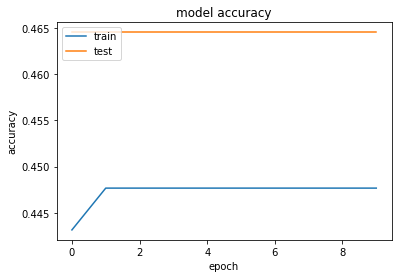

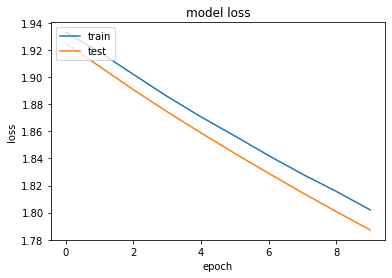

In [ ]:
# Plot history for accuracy and loss
plot_model(history.history['accuracy'], history.history['val_accuracy'], 
           'model accuracy', 'accuracy', 'epoch')
plot_model(history.history['loss'], history.history['val_loss'], 
           'model loss', 'loss', 'epoch')

In [ ]:
# CNN on GloVe pretrained inputs
!wget --no-check-certificate \
http://nlp.stanford.edu/data/glove.6B.zip \
-O /tmp/glove.6B.zip

import zipfile
with zipfile.ZipFile('/tmp/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

--2022-05-13 01:46:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-13 01:46:58--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-13 01:46:58--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/tmp/glove.6B.zip’

/t

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
# CNN with GloVe embedding layer

embedding_layer = layers.Embedding(input_dim=len(word_index) + 1,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=17,
                            trainable=False)


model = Sequential()
model.add(embedding_layer)
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu')) 
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(32, input_shape=(vocab_size, )))
model.add(layers.Activation(activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(num_class))
model.add(layers.Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_x_seq, train_y, epochs=20, validation_data=(test_x_seq, test_y))
embedded_results = history

Epoch 1/20
208/208 [==============================] - 3s 10ms/step - loss: 1.0948 - accuracy: 0.6101 - val_loss: 0.7812 - val_accuracy: 0.7164
Epoch 2/20
208/208 [==============================] - 2s 9ms/step - loss: 0.7833 - accuracy: 0.7298 - val_loss: 0.6577 - val_accuracy: 0.7689
Epoch 3/20
208/208 [==============================] - 2s 8ms/step - loss: 0.6489 - accuracy: 0.7784 - val_loss: 0.6312 - val_accuracy: 0.7767
Epoch 4/20
208/208 [==============================] - 2s 9ms/step - loss: 0.5955 - accuracy: 0.7956 - val_loss: 0.6272 - val_accuracy: 0.7858
Epoch 5/20
208/208 [==============================] - 2s 9ms/step - loss: 0.5235 - accuracy: 0.8181 - val_loss: 0.5902 - val_accuracy: 0.7948
Epoch 6/20
208/208 [==============================] - 2s 8ms/step - loss: 0.4969 - accuracy: 0.8291 - val_loss: 0.5991 - val_accuracy: 0.7894
Epoch 7/20
208/208 [==============================] - 2s 9ms/step - loss: 0.4647 - accuracy: 0.8374 - val_loss: 0.5978 - val_accuracy: 0.8033
Epoch

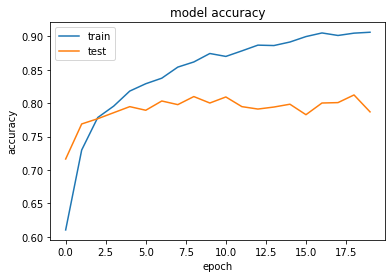

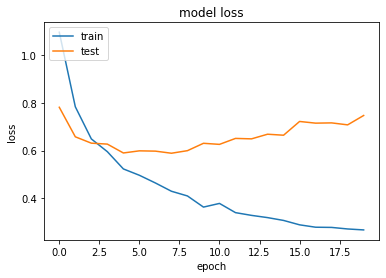

In [ ]:
# Plot history for accuracy and loss
plot_model(history.history['accuracy'], history.history['val_accuracy'], 
           'model accuracy', 'accuracy', 'epoch')
plot_model(history.history['loss'], history.history['val_loss'], 
           'model loss', 'loss', 'epoch')

In [ ]:
# GloVe pretrained - hyperparameter optimization
# Original code source: https://cnvrg.io/cnn-sentence-classification/

#def model_to_optimize(num_filters, kernel_size)

def model_to_optimize(num_filters, kernel_size, learning_rate):
    model = Sequential([
                        embedding_layer,
                        layers.Conv1D(num_filters, kernel_size, activation='relu'),
                        layers.GlobalMaxPooling1D(),
                        layers.Dense(32, activation='relu'),
                        layers.Dropout(0.25),
                        layers.Dense(num_class, activation='sigmoid')])
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    return model

In [ ]:
params = {
    "num_filters":[32, 64, 128],
    "kernel_size":[3, 5, 7],
    "learning_rate":[0.1,0.01,0.001]
}


model = KerasClassifier(build_fn=model_to_optimize,
                            epochs=10,
                           batch_size=80,
                            verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
search = GridSearchCV(estimator=model, param_grid=params, cv=5, verbose=1)
search_result = search.fit(train_x_seq, train_y)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Epoch 1/10
67/67 [==============================] - 1s 7ms/step - loss: 1.7428 - accuracy: 0.4611
Epoch 2/10
67/67 [==============================] - 0s 7ms/step - loss: 1.3693 - accuracy: 0.4738
Epoch 3/10
67/67 [==============================] - 0s 7ms/step - loss: 1.3592 - accuracy: 0.4787
Epoch 4/10
67/67 [==============================] - 0s 7ms/step - loss: 1.3356 - accuracy: 0.4919
Epoch 5/10
67/67 [==============================] - 0s 7ms/step - loss: 1.3357 - accuracy: 0.5157
Epoch 6/10
67/67 [==============================] - 0s 7ms/step - loss: 1.3708 - accuracy: 0.4862
Epoch 7/10
67/67 [==============================] - 0s 6ms/step - loss: 1.3878 - accuracy: 0.4911
Epoch 8/10
67/67 [==============================] - 0s 7ms/step - loss: 1.4171 - accuracy: 0.4657
Epoch 9/10
67/67 [==============================] - 0s 7ms/step - loss: 1.4568 - accuracy: 0.4515
Epoch 10/10
17/17 [==============================] - 0s 

In [ ]:
test_accuracy = search.score(test_x_seq, test_y)
search.best_params_
# Results
df = pd.DataFrame(search.cv_results_)
df.to_csv('AIML428_Project_Results')
df

21/21 [==============================] - 0s 5ms/step - loss: 0.6021 - accuracy: 0.7972


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel_size,param_learning_rate,param_num_filters,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.733000,0.194309,0.382637,0.157311,3,0.1,32,"{'kernel_size': 3, 'learning_rate': 0.1, 'num_...",0.438491,0.463396,0.435472,0.446792,0.467925,0.450415,0.013067,23
1,9.929192,1.980762,0.325676,0.022415,3,0.1,64,"{'kernel_size': 3, 'learning_rate': 0.1, 'num_...",0.438491,0.463396,0.435472,0.516981,0.467925,0.464453,0.029279,22
2,9.885312,1.494898,0.356337,0.012572,3,0.1,128,"{'kernel_size': 3, 'learning_rate': 0.1, 'num_...",0.438491,0.463396,0.435472,0.441509,0.467925,0.449358,0.013523,25
3,6.634642,2.197348,0.325929,0.026231,3,0.01,32,"{'kernel_size': 3, 'learning_rate': 0.01, 'num...",0.773585,0.766038,0.735094,0.775849,0.769057,0.763925,0.014816,16
4,10.023085,1.867595,0.319409,0.028548,3,0.01,64,"{'kernel_size': 3, 'learning_rate': 0.01, 'num...",0.776604,0.774340,0.769811,0.747925,0.756226,0.764981,0.011078,14
5,9.972252,1.215973,0.504361,0.319121,3,0.01,128,"{'kernel_size': 3, 'learning_rate': 0.01, 'num...",0.765283,0.773585,0.756226,0.760755,0.750189,0.761208,0.007953,18
6,6.821115,2.044341,0.310783,0.042061,3,0.001,32,"{'kernel_size': 3, 'learning_rate': 0.001, 'nu...",0.775849,0.760000,0.760755,0.761509,0.756981,0.763019,0.006597,17
7,9.522976,1.772530,0.500660,0.353452,3,0.001,64,"{'kernel_size': 3, 'learning_rate': 0.001, 'nu...",0.784906,0.773585,0.774340,0.777358,0.765283,0.775094,0.006332,10
8,10.531810,0.693919,0.357673,0.023713,3,0.001,128,"{'kernel_size': 3, 'learning_rate': 0.001, 'nu...",0.791698,0.794717,0.787925,0.781132,0.774340,0.785962,0.007373,4
9,9.127066,1.807125,0.362011,0.035701,5,0.1,32,"{'kernel_size': 5, 'learning_rate': 0.1, 'num_...",0.529811,0.463396,0.488302,0.448302,0.533585,0.492679,0.034346,19


In [ ]:
times = df['mean_fit_time'] + df['mean_score_time']
search.best_params_

{'kernel_size': 5, 'learning_rate': 0.001, 'num_filters': 64}

In [ ]:
# print(df['mean_test_score'])

# Highest mean test score + paramaters

best = search.best_estimator_
search.best_score_

0.7960754632949829

[Text(0.5, 1.0, 'All Scores')]

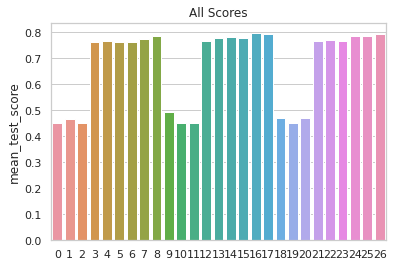

In [ ]:
# All scores barplot
scores = df['mean_test_score']
df1 = pd.DataFrame({'mean_test_score': df['mean_test_score'], 
                   'kernel': df['param_kernel_size'],
                   'lr': df['param_learning_rate'],
                   'filters': df['param_num_filters']})
# print(x)

sns.set_theme(style="whitegrid")
sns.barplot(data=df1, x=df1['mean_test_score'].index, y='mean_test_score').set(title='All Scores')

[Text(0.5, 1.0, 'Kernel Size Scores')]

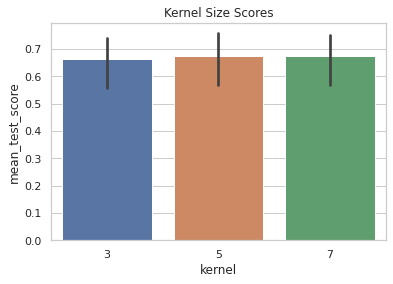

In [ ]:
# Barplot - by kernel size
sns.barplot(data=df1, x='kernel', y='mean_test_score').set(title='Kernel Size Scores')

[Text(0.5, 1.0, 'Learning Rate Scores')]

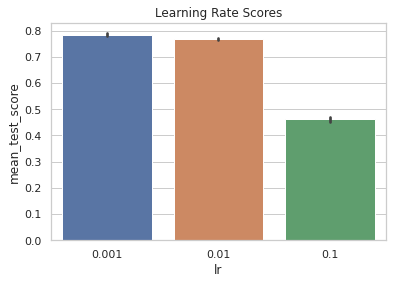

In [ ]:
# Barplot - by learning rate
sns.barplot(data=df1, x='lr', y='mean_test_score').set(title='Learning Rate Scores')

[Text(0.5, 1.0, 'Filter Scores')]

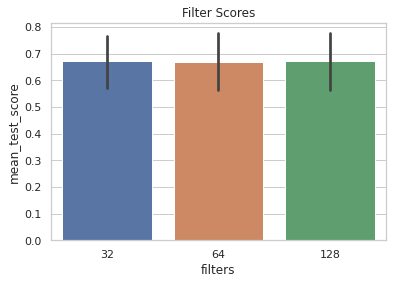

In [ ]:
# Barplot - by num filters
sns.barplot(data=df1, x='filters', y='mean_test_score').set(title='Filter Scores')

[Text(0.5, 1.0, 'Filter Scores')]

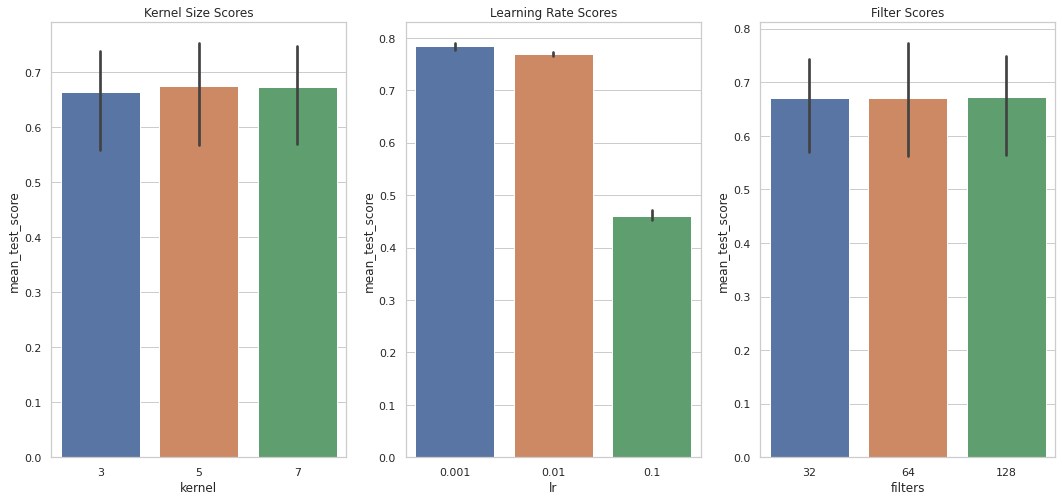

In [ ]:
# Facet grid
rcParams['figure.figsize'] = 18,8
fig, axs = plt.subplots(ncols=3)
sns.barplot(data=df1, x='kernel', y='mean_test_score', ax=axs[0]).set(title='Kernel Size Scores')
sns.barplot(data=df1, x='lr', y='mean_test_score', ax=axs[1]).set(title='Learning Rate Scores')
sns.barplot(data=df1, x='filters', y='mean_test_score', ax=axs[2]).set(title='Filter Scores')

In [ ]:
# Comparison - original CNN, best CNN, other classifiers
trigram_result


[('Logistic Regression', 0.7091128545564273, 7.549923896789551),
 ('Linear SVC', 0.6608328304164152, 0.48207736015319824),
 ('LinearSVC with L1-based feature selection',
  0.7127338563669282,
  1.7540600299835205),
 ('Multinomial NB', 0.6674713337356669, 0.256641149520874),
 ('Bernoulli NB', 0.587809293904647, 0.3033640384674072),
 ('Ridge Classifier', 0.6885938442969222, 0.6054179668426514),
 ('AdaBoost', 0.4996982498491249, 1.4704768657684326),
 ('Perceptron', 0.5552202776101388, 0.35808753967285156),
 ('Passive-Aggresive', 0.5606517803258901, 0.47369980812072754),
 ('Nearest Centroid', 0.5618587809293905, 0.30628252029418945)]

In [ ]:
print(str(trigram_result[0][0]) + ": " + str(trigram_result[0][1] * 100) + "%")

Logistic Regression: 70.91128545564273%


In [ ]:
def float_string(input):
  return "{:.2f}".format(input)

def format_output():
  names = []
  accuracies = []
  for i in range(len(trigram_result)):
    names.append(str(trigram_result[i][0]))
    accuracies.append(trigram_result[i][1])
  names.append("Baseline CNN")
  names.append("Embedded CNN")
  accuracies.append(original_results[1])
  accuracies.append(search.best_score_)
  return names, accuracies

def output_accuracies_list(names = format_output()[0], accuracies = format_output()[1]):
  output = "Classifier Accuracies:\n-------------------\n"
  for i in range(len(names)):
    output += str(names[i]) + ": " + str(float_string(accuracies[i]*100)) + "%\n"
  return output

def plot_accuracies():
  rcParams['figure.figsize'] = 14,8
  data = {'names': format_output()[0],
          'accuracies': format_output()[1]}
  plot = sns.barplot(x = 'names', y = 'accuracies', data = data)
  plot.set(title="All Accuracies", xLabel = "Classifiers", yLabel="Accuracy")
  plot.set_xticklabels(plot.get_xticklabels(),rotation = 30)
  return plot

In [ ]:
print(output_accuracies_list())

Classifier Accuracies:
-------------------
Logistic Regression: 70.91%
Linear SVC: 66.08%
LinearSVC with L1-based feature selection: 71.27%
Multinomial NB: 66.75%
Bernoulli NB: 58.78%
Ridge Classifier: 68.86%
AdaBoost: 49.97%
Perceptron: 55.52%
Passive-Aggresive: 56.07%
Nearest Centroid: 56.19%
Baseline CNN: 47.50%
Embedded CNN: 79.61%



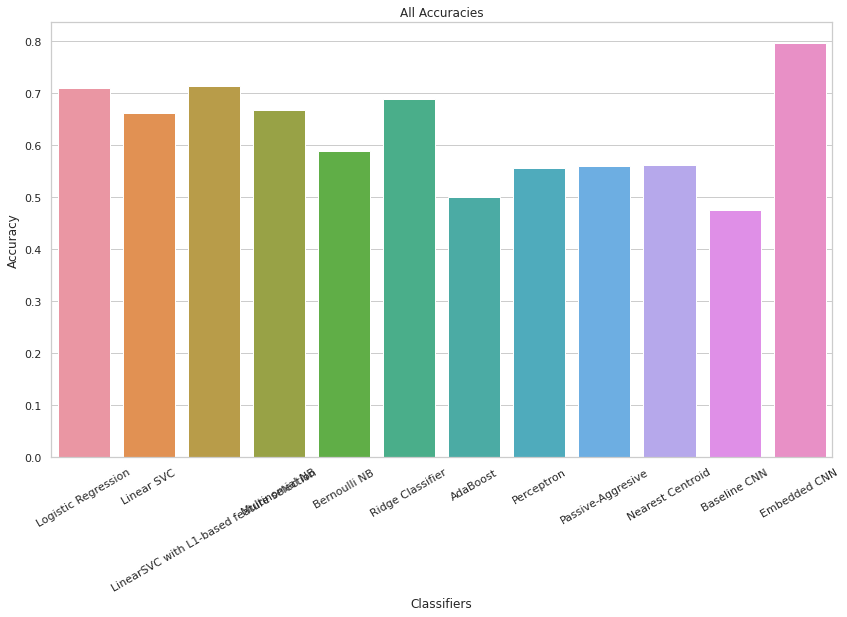

In [ ]:
plot_accuracies()